Sevahn Vorperian -- Quake Lab
<br>
<br>
Visualize brain cell type markers within the Mathys et al NCI data.
<br>
this script requires the Mathys et al. data and metadata, which is accessible with permission from Synapse.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl


import sklearn.decomposition, sklearn.cluster
from nheatmap import nhm, scripts
import matplotlib.pyplot as plt
import matplotlib as mpl


import os

#For editable text. Except latex text is still shapes
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")
font = {'size' : 6}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}
mpl.rc('font', **font)
mpl.rc('lines', **lines)
mpl.rc('figure', **fig)

#Set style
sns.set(style = "whitegrid", palette="pastel", color_codes=True)

In [2]:
def save_figure_pdf(fig, path_to_save):
	'''
	Utility fxn to save a figure without having to retype all the required options.
	Input:
		fig - a matplotlib.pyplot.figure instance with the figure you'd like to save
		path_to_save - the path you'd like to save the figure to
	Returns: Nothing but there should now be a pdf version in 300 dpi with a transparent bkg at path_to_save
	'''
	fig.savefig(path_to_save, dpi = 150, 
                bbox_inches = 'tight', transparent = True)

In [3]:
cell_pal = {'Astrocyte': '#96C9DC',
 'Excitatory Neuron': '#fb5607',
 'Inhibitory Neuron': '#ff006e',
 'Oligodendrocyte': '#8338ec',
 'Oligodendrocyte Precursor Cell': '#3a86ff'}

In [4]:
sns.color_palette(list(cell_pal.values()))

[(0.5882352941176471, 0.788235294117647, 0.8627450980392157),
 (0.984313725490196, 0.33725490196078434, 0.027450980392156862),
 (1.0, 0.0, 0.43137254901960786),
 (0.5137254901960784, 0.2196078431372549, 0.9254901960784314),
 (0.22745098039215686, 0.5254901960784314, 1.0)]

In [5]:
mapping = {}
goodCells = ['Ast', 'Ex', 'In', 'Oli', 'Opc']
fullCellNames = np.unique(list(cell_pal.keys()))
for i, c in enumerate(goodCells):
    mapping[c] = fullCellNames[i]    

In [6]:
# read in adata and normalize
adata = sc.read_h5ad("../brain/brain-mathys.h5ad")
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

In [29]:
markers = pd.read_csv("brainGenes_forCIS_NORMAL_01212021.csv",
                     sep = ",", index_col = 0).T
degDict = {}
for i in markers:
    cellName = i.split("-")[0]
    if cellName != "Mic":
        fullCellName = mapping[cellName]
        degDict[fullCellName] = markers[i].dropna().tolist()

In [30]:
for i in markers:
    print(len(markers[i].dropna().tolist()))

brainGini = pd.read_csv("../signatures_git/gini6_perCluster_brain_NORMAL_01212021.csv",
                       sep = ",", index_col = 0)

22
70
8
2
25
24


In [31]:
# now subset for healthy only
ros = pd.read_csv("../brain/ROSMAP-DLPFC-Bulk-sample-metadata.csv", sep = ",", index_col = 0)
# in the 'diagnosis column' the options are ['AD', 'MCI', 'Normal', 'Other']
control = ros[ros["diagnosis"] == "Normal"] # only get brain samples from healthy patients
ctrlProjID = control["projid"].tolist()
ctrlProjID = [str(i) for i in ctrlProjID]
os.system("echo " + str(len(ctrlProjID)))
tissSC = adata[adata.obs["projid"].isin(ctrlProjID)]
os.system("echo " + str(tissSC.obs.shape[0]))

0

In [32]:
np.unique(tissSC.obs["broad.cell.type"])

array(['Ast', 'End', 'Ex', 'In', 'Mic', 'Oli', 'Opc', 'Per'], dtype=object)

In [33]:
tissSC = tissSC[tissSC.obs["broad.cell.type"].isin(goodCells)]

In [34]:
tissSC

View of AnnData object with n_obs × n_vars = 10735 × 17926
    obs: 'projid', 'tsne1', 'tsne2', 'pre.cluster', 'broad.cell.type', 'Subcluster'
    uns: 'log1p'

In [35]:
df = pd.DataFrame(tissSC.X)
dfr = tissSC.obs["broad.cell.type"].to_frame()
df.index = dfr.index
df.columns = tissSC.var_names

In [36]:
dfr.shape

(10735, 1)

In [37]:
allMarkers = list(degDict.values())
allMarkers = [j for sub in allMarkers for j in sub] 

In [38]:
df = df[allMarkers] # only get the ones in the relevant space
df.shape

(10735, 149)

In [39]:
revDict = {}
for i in degDict:
    for gene in degDict[i]:
        revDict[gene] = [i]

In [40]:
dfc = pd.DataFrame.from_dict(revDict).T

In [41]:
df = df.loc[dfr["broad.cell.type"].sort_values().index]
dfr = dfr["broad.cell.type"].sort_values(ascending = True)

In [42]:
dfr = dfr.to_frame()

In [43]:
cmaps={'cell cluster':'Paired', 'PC1':'RdYlGn', 'gene cluster':'inferno',
        'PC score':'gist_heat', 'PC score 2':'rainbow'}
cell_pal = {'Astrocyte': '#96C9DC',
 'Excitatory Neuron': '#fb5607',
 'Inhibitory Neuron': '#ff006e',
 'Oligodendrocyte': '#8338ec',
 'Oligodendrocyte Precursor Cell': '#3a86ff'}
cmaps = {"broad.cell.type":cell_pal, 0:cell_pal }

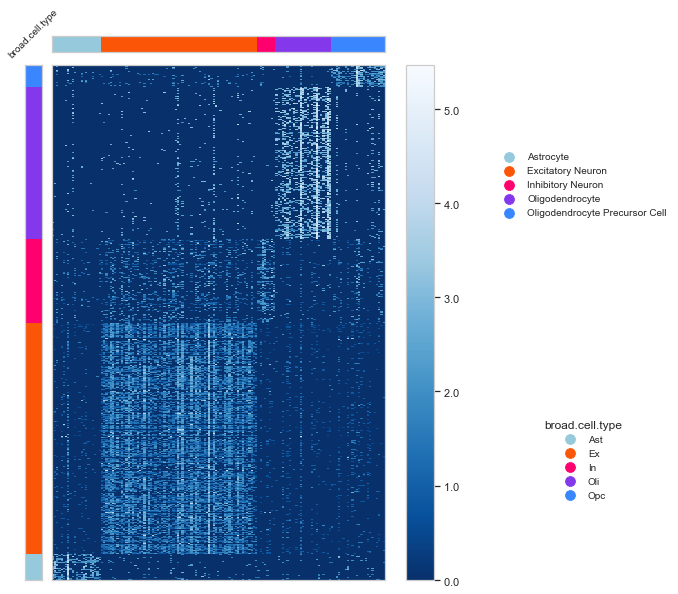

In [44]:
g = nhm(data=df, dfr=dfr, dfc=dfc, figsize=(10, 10), 
           linewidths=0, showxticks=False, cmaps=cmaps, cmapCenter = "Blues_r")
fig, plots = g.run()

In [45]:
#save_figure_pdf(fig, "brain_sig_heatmap_04032021.png")

In [46]:
clear all